# PyTorch and fastai implementations of SGD with momentum

In [22]:
from fastai2.vision.all import *
from fastai2.callback.fp16 import *

## Data

In [2]:
path = untar_data(URLs.IMAGENETTE)
Path.BASE_PATH = path
path.ls()

(#2) [Path('val'),Path('train')]

In [3]:
(path/'train').ls()

(#10) [Path('train/n03028079'),Path('train/n02102040'),Path('train/n03000684'),Path('train/n01440764'),Path('train/n03888257'),Path('train/n03425413'),Path('train/n02979186'),Path('train/n03394916'),Path('train/n03417042'),Path('train/n03445777')]

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(valid_name='val'),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                Normalize.from_stats(*imagenet_stats)])

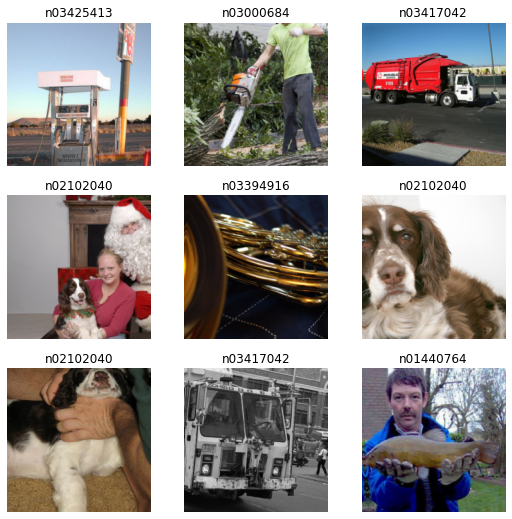

In [8]:
dls = dblock.dataloaders(path)
dls.show_batch()

### Model

In [9]:
model = xresnet50()

## fastai implementation using optimizer callbacks

In [32]:
def first_moment(p, beta1, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': beta1*grad_avg + (1-beta1)*p.grad.data}

In [33]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)

In [38]:
opt_func = partial(Optimizer, cbs=[first_moment, momentum_step], beta1=0.9)

### create and train learner

In [40]:
learn = Learner(dls, model, opt_func=opt_func, metrics=accuracy).to_fp16()

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.03981071710586548)

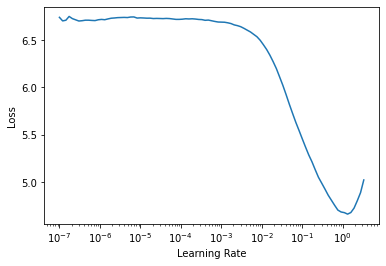

In [41]:
learn.lr_find()

In [42]:
lr=1e-1

In [43]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.850220,1.726653,0.445605,01:30
1,1.411375,1.510671,0.526115,01:28
2,1.144577,1.077708,0.663949,01:27
3,0.978612,0.958542,0.703694,01:28
4,0.885417,0.894757,0.727643,01:28


## PyTorch Implementation

In [45]:
dls.c

10